# CNN Explainability Demo

This notebook demonstrates three key techniques for understanding what Convolutional Neural Networks learn:

1. **Filter Visualizations**: See what patterns individual filters detect
2. **Activation Maximization**: Generate images that maximally activate specific filters
3. **Class Activation Maps (Grad-CAM)**: Visualize which input regions drive predictions

We'll use a simple 2-layer CNN trained on either MNIST or Fashion-MNIST to keep things interpretable.

## Configuration

Choose your dataset and training parameters here.

In [ ]:
# Dataset selection - change this to 'fashion_mnist' to switch datasets
DATASET = 'mnist'  # Options: 'mnist' or 'fashion_mnist'

# Training parameters
TRAIN_NEW_MODEL = False  # Set to True to train from scratch, False to load pre-trained
EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# Model will be saved/loaded from:
MODEL_PATH = f'saved_models/{DATASET}_simple_cnn.h5'

print(f"Configuration: {DATASET.upper()} dataset")
print(f"Model path: {MODEL_PATH}")

Configuration: MNIST dataset
Model path: saved_models/mnist_simple_cnn.h5


## Imports and Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Class labels for visualization
if DATASET == 'mnist':
    CLASS_NAMES = [str(i) for i in range(10)]
else:  # fashion_mnist
    CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

TensorFlow version: 2.20.0
GPU available: False


## Load Dataset

In [3]:
# Load dataset
if DATASET == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
else:  # fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess data
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Normalize to [-1, 1] range
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2

print(f"Loaded {DATASET}: {len(x_train)} training samples, {len(x_test)} test samples")
print(f"Image shape: {x_train.shape[1:]}")
print(f"Value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

Loaded mnist: 60000 training samples, 10000 test samples
Image shape: (28, 28, 1)
Value range: [-1.00, 1.00]


## Define Simple CNN Architecture

We use a deliberately simple architecture:
- **Conv Layer 1**: 8 filters, 3x3 kernel
- **Conv Layer 2**: 8 filters, 3x3 kernel
- **Fully Connected**: Output layer

This small architecture makes it easier to visualize and understand what each filter learns.

In [4]:
def create_simple_cnn():
    """Create a simple 2-layer CNN for visualization."""
    model = models.Sequential([
        # First convolutional layer: 8 filters, 3x3 kernel
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', 
                     input_shape=(28, 28, 1), name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),  # 28x28 -> 14x14
        
        # Second convolutional layer: 8 filters, 3x3 kernel
        layers.Conv2D(4, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),  # 14x14 -> 7x7
        
        # Fully connected layer
        layers.Flatten(),
        layers.Dense(10, name='output')
    ])
    
    return model

# Create model
model = create_simple_cnn()
model.summary()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

/Users/ssogden/repos/classes/CST463-golden/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,342 (9.15 KB)

 Trainable params: 2,342 (9.15 KB)

 Non-trainable params: 0 (0.00 B)

## Training (or Load Pre-trained Model)

In [5]:
# Train or load model
if TRAIN_NEW_MODEL:
    print("Training new model...")
    
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_test, y_test),
        verbose=1
    )
    
    # Evaluate final accuracy
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nFinal test accuracy: {test_acc*100:.2f}%")
    
    # Save the trained model
    os.makedirs('saved_models', exist_ok=True)
    model.save(MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")
    
else:
    if os.path.exists(MODEL_PATH):
        print(f"Loading pre-trained model from {MODEL_PATH}")
        model = keras.models.load_model(MODEL_PATH)
        
        # Evaluate to show performance
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        print(f"Model loaded successfully!")
        print(f"Test accuracy: {test_acc*100:.2f}%")
    else:
        print(f"No pre-trained model found at {MODEL_PATH}")
        print("Set TRAIN_NEW_MODEL = True to train a new model")

Training new model...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8093 - loss: 0.6424 - val_accuracy: 0.9238 - val_loss: 0.2499
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9389 - loss: 0.2036 - val_accuracy: 0.9532 - val_loss: 0.1508
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9576 - loss: 0.1406 - val_accuracy: 0.9644 - val_loss: 0.1116
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9651 - loss: 0.1142 - val_accuracy: 0.9695 - val_loss: 0.0934
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9695 - loss: 0.0997 - val_accuracy: 0.9720 - val_loss: 0.0830



Final test accuracy: 97.20%
Model saved to saved_models/mnist_simple_cnn.h5


---
# Method 1: Filter Visualizations

We'll visualize what patterns the convolutional filters learn in two ways:
1. **Filter weights**: The raw learned kernels
2. **Feature maps**: What the filters activate on when shown real images

## 1.1: Visualize Filter Weights (Raw Values + Heatmaps)


CONV1 - Filter Weights
Shape: (3, 3, 1, 8) (height, width, in_channels, filters)

Raw weight values for Filter 0, Channel 0:
[[-0.37896422 -0.49241692 -0.11159258]
 [ 0.26522166 -0.25866368  0.03942073]
 [ 0.5167847   0.40683505  0.05655925]]

Min: -0.4924, Max: 0.5168



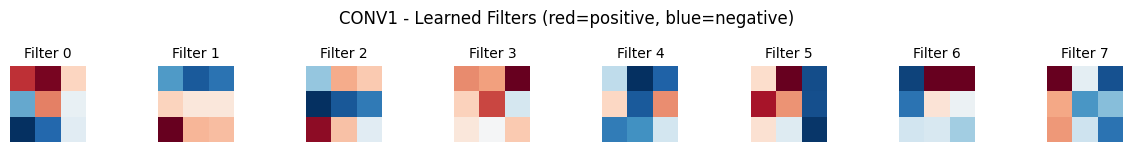


CONV2 - Filter Weights
Shape: (3, 3, 8, 4) (height, width, in_channels, filters)

Raw weight values for Filter 0, Channel 0:
[[-0.06146873 -0.04542069 -0.5543591 ]
 [ 0.4688225   0.43856588 -0.08236688]
 [ 0.26103443  0.13101475 -0.04104816]]

Min: -0.5544, Max: 0.4688



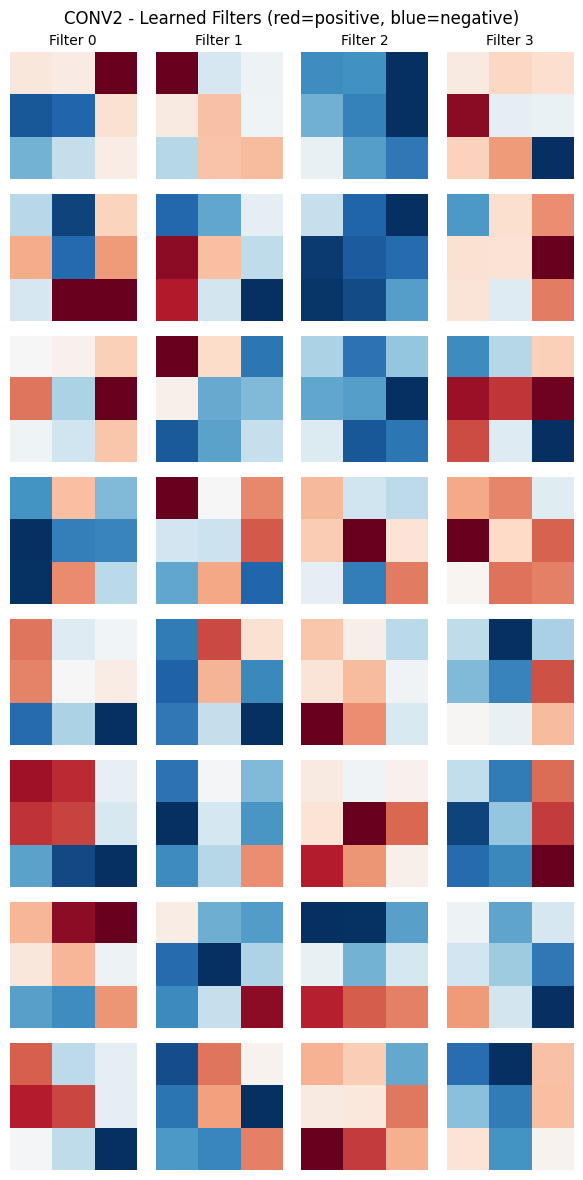

In [6]:
def visualize_conv_filters(model, layer_name):
    """
    Visualize the learned filters of a convolutional layer.
    Shows both raw float values and heatmap visualizations.
    """
    # Get the layer
    layer = model.get_layer(layer_name)
    
    # Get filter weights: shape is (height, width, in_channels, out_channels)
    weights = layer.get_weights()[0]  # [0] is weights, [1] is biases
    num_filters = weights.shape[3]
    in_channels = weights.shape[2]
    
    print(f"\n{'='*60}")
    print(f"{layer_name.upper()} - Filter Weights")
    print(f"{'='*60}")
    print(f"Shape: {weights.shape} (height, width, in_channels, filters)\n")
    
    # Print raw values for first filter as example
    print(f"Raw weight values for Filter 0, Channel 0:")
    print(weights[:, :, 0, 0])
    print(f"\nMin: {weights[:, :, 0, 0].min():.4f}, Max: {weights[:, :, 0, 0].max():.4f}\n")
    
    # Visualize all filters
    fig, axes = plt.subplots(in_channels, num_filters, figsize=(num_filters * 1.5, in_channels * 1.5))
    if in_channels == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(in_channels):
        for j in range(num_filters):
            ax = axes[i, j] if in_channels > 1 else axes[0, j]
            
            # Get filter weights for this channel and filter
            w = weights[:, :, i, j]
            
            # Normalize for visualization
            im = ax.imshow(w, cmap='RdBu', vmin=-abs(w).max(), vmax=abs(w).max())
            
            if i == 0:
                ax.set_title(f'Filter {j}', fontsize=10)
            if j == 0:
                ax.set_ylabel(f'In Ch {i}', fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'{layer_name.upper()} - Learned Filters (red=positive, blue=negative)', fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualize both convolutional layers
visualize_conv_filters(model, 'conv1')
visualize_conv_filters(model, 'conv2')

## 1.2: Visualize Feature Maps (Filter Activations on Real Images)

In [ ]:
def visualize_feature_maps(model, image, label, class_names):
    """
    Visualize what each filter "sees" when processing a real image.
    """
    # Get predictions
    image_batch = np.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(image_batch, verbose=0)
    prediction = np.argmax(predictions[0])
    
    # Create an explicit input tensor
    input_tensor = keras.Input(shape=(28, 28, 1))
    
    # Create models that output intermediate layer activations using explicit input
    conv1_output = model.get_layer('conv1')(input_tensor)
    conv1_model = keras.Model(inputs=input_tensor, outputs=conv1_output)
    
    # For conv2, we need to pass through pool1 first
    pool1_output = model.get_layer('pool1')(conv1_output)
    conv2_output = model.get_layer('conv2')(pool1_output)
    conv2_model = keras.Model(inputs=input_tensor, outputs=conv2_output)
    
    # Get activations
    conv1_acts = conv1_model.predict(image_batch, verbose=0)[0]  # Shape: (H, W, num_filters)
    conv2_acts = conv2_model.predict(image_batch, verbose=0)[0]  # Shape: (H, W, num_filters)
    
    # Get filter weights and number of filters
    conv1_weights = model.get_layer('conv1').get_weights()[0]  # Shape: (3, 3, 1, num_filters)
    conv2_weights = model.get_layer('conv2').get_weights()[0]  # Shape: (3, 3, in_channels, num_filters)
    
    num_conv1_filters = conv1_weights.shape[3]
    num_conv2_filters = conv2_weights.shape[3]
    
    # Display original image
    input_img = image[:, :, 0]
    
    print(f"\nTrue Label: {class_names[label]} | Prediction: {class_names[prediction]}")
    
    # Plot Conv1: Filters + Activations
    fig, axes = plt.subplots(3, num_conv1_filters, figsize=(num_conv1_filters * 2, 6))
    
    # Handle case where there's only one filter
    if num_conv1_filters == 1:
        axes = axes.reshape(3, 1)
    
    # Row 1: Original image in first cell, rest empty
    axes[0, 0].imshow(input_img, cmap='gray')
    axes[0, 0].set_title('Input', fontsize=9)
    axes[0, 0].axis('off')
    
    for i in range(1, num_conv1_filters):
        axes[0, i].axis('off')
    
    # Row 2: All filter weights
    for i in range(num_conv1_filters):
        filter_weights = conv1_weights[:, :, 0, i]
        axes[1, i].imshow(filter_weights, cmap='RdBu', vmin=-abs(filter_weights).max(), vmax=abs(filter_weights).max())
        axes[1, i].set_title(f'Filter {i}', fontsize=9)
        axes[1, i].axis('off')
    
    # Row 3: All activations
    for i in range(num_conv1_filters):
        axes[2, i].imshow(conv1_acts[:, :, i], cmap='viridis')
        axes[2, i].set_title(f'Act {i}', fontsize=9)
        axes[2, i].axis('off')
    
    plt.suptitle(f'Conv1: {num_conv1_filters} Filters - Weights (middle) → Activations (bottom)', fontsize=12, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Plot Conv2: Show filter weights for first input channel + activations
    fig, axes = plt.subplots(2, num_conv2_filters, figsize=(num_conv2_filters * 2, 4))
    
    # Handle case where there's only one filter
    if num_conv2_filters == 1:
        axes = axes.reshape(2, 1)
    
    # Row 1: Show filter weights (first input channel only for simplicity)
    for i in range(num_conv2_filters):
        filter_weights = conv2_weights[:, :, 0, i]  # Just show first input channel
        axes[0, i].imshow(filter_weights, cmap='RdBu', vmin=-abs(filter_weights).max(), vmax=abs(filter_weights).max())
        axes[0, i].set_title(f'Filter {i}\n(ch 0)', fontsize=8)
        axes[0, i].axis('off')
    
    # Row 2: Activations
    for i in range(num_conv2_filters):
        axes[1, i].imshow(conv2_acts[:, :, i], cmap='viridis')
        axes[1, i].set_title(f'Act {i}', fontsize=9)
        axes[1, i].axis('off')
    
    plt.suptitle(f'Conv2: {num_conv2_filters} Filters - Weights (top, 1st input channel) → Activations (bottom)', fontsize=12, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print some activation statistics
    print("\nActivation statistics for Conv1 Filter 0:")
    print(f"Shape: {conv1_acts[:, :, 0].shape}")
    print(f"Min: {conv1_acts[:, :, 0].min():.4f}, Max: {conv1_acts[:, :, 0].max():.4f}")
    print(f"Mean: {conv1_acts[:, :, 0].mean():.4f}, Std: {conv1_acts[:, :, 0].std():.4f}")

# Get a sample image from test set
sample_idx = 0  # Change this to see different examples
sample_image = x_test[sample_idx]
sample_label = y_test[sample_idx]

visualize_feature_maps(model, sample_image, sample_label, CLASS_NAMES)

Try different sample images to see how filters respond differently:

In [ ]:
# Visualize multiple examples
for idx in [0, 10, 100, 500]:  # Different samples
    sample_image = x_test[idx]
    sample_label = y_test[idx]
    visualize_feature_maps(model, sample_image, sample_label, CLASS_NAMES)

---
# Method 2: Activation Maximization

Instead of showing what filters respond to on real images, we can **generate** images that maximally activate specific filters. This helps us understand what pattern the filter is "looking for."

We start with random noise and use gradient ascent to modify the input to maximize the activation of a chosen filter.

In [ ]:
def activation_maximization(model, layer_name, filter_idx, iterations=100, lr=1.0):
    """
    Generate an input image that maximally activates a specific filter.
    
    Args:
        model: The CNN model
        layer_name: Which layer to maximize ('conv1' or 'conv2')
        filter_idx: Which filter in that layer to maximize
        iterations: Number of optimization steps
        lr: Learning rate for gradient ascent
    """
    # Get the filter weights to display
    layer = model.get_layer(layer_name)
    filter_weights = layer.get_weights()[0]  # Shape: (3, 3, in_channels, num_filters)
    
    # Create an explicit input tensor and build the model up to target layer
    input_tensor = keras.Input(shape=(28, 28, 1))
    
    # Build layers up to the target layer
    x = model.get_layer('conv1')(input_tensor)
    if layer_name == 'conv1':
        layer_output = x
        # For conv1, show the single input channel
        target_filter = filter_weights[:, :, 0, filter_idx]
    else:
        x = model.get_layer('pool1')(x)
        x = model.get_layer('conv2')(x)
        if layer_name == 'conv2':
            layer_output = x
            # For conv2, show all input channels
            target_filter = filter_weights[:, :, :, filter_idx]
        else:
            # Continue building if needed for other layers
            layer_output = x
            target_filter = None
    
    feature_extractor = keras.Model(inputs=input_tensor, outputs=layer_output)
    
    # Start with random noise (scaled to match expected input range)
    input_img = tf.Variable(tf.random.normal((1, 28, 28, 1)) * 0.1)
    
    # Track loss over iterations
    losses = []
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            # Forward pass
            activation = feature_extractor(input_img)
            
            # Get the activation of the target filter
            # Shape: (1, height, width, num_filters)
            filter_activation = activation[:, :, :, filter_idx]
            
            # We want to MAXIMIZE the mean activation
            loss = -tf.reduce_mean(filter_activation)
        
        losses.append(-loss.numpy())  # Store positive value for plotting
        
        # Get gradients
        grads = tape.gradient(loss, input_img)
        
        # Normalize gradients to prevent explosion
        grads = grads / (tf.math.reduce_std(grads) + 1e-8)
        
        # Gradient ascent step
        input_img.assign_add(lr * grads)
        
        # Clip values to reasonable range (instead of aggressive normalization)
        input_img.assign(tf.clip_by_value(input_img, -2, 2))
        
        if (i + 1) % 20 == 0:
            print(f"Iteration {i+1}/{iterations}, Activation: {losses[-1]:.4f}")
    
    # Visualize result
    result_img = input_img[0, :, :, 0].numpy()
    
    # Create figure based on layer type
    if layer_name == 'conv1':
        # Simple 3-panel layout for conv1
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Show filter weights
        axes[0].imshow(target_filter, cmap='RdBu', vmin=-abs(target_filter).max(), vmax=abs(target_filter).max())
        axes[0].set_title(f'{layer_name.upper()} Filter {filter_idx}\nWeights (3x3)')
        axes[0].axis('off')
        
        # Show generated image
        axes[1].imshow(result_img, cmap='gray', vmin=-2, vmax=2)
        axes[1].set_title(f'Generated Image\nMaximizes Activation')
        axes[1].axis('off')
        
        # Show optimization progress
        axes[2].plot(losses)
        axes[2].set_xlabel('Iteration')
        axes[2].set_ylabel('Mean Activation')
        axes[2].set_title('Optimization Progress')
        axes[2].grid(True)
        
    else:
        # For conv2, create a more complex layout with filter grid
        num_channels = filter_weights.shape[2]  # Number of input channels
        rows = 2
        cols = int(np.ceil(num_channels / 2))
        
        # Create figure with custom layout: filter grid | generated image | progress plot
        fig = plt.figure(figsize=(16, 5))
        gs = fig.add_gridspec(2, 3, width_ratios=[1.5, 1, 1.5], hspace=0.3, wspace=0.3)
        
        # Left: Grid of filter weights for all input channels
        ax_filters = fig.add_subplot(gs[:, 0])
        ax_filters.axis('off')
        
        # Create subplots for each channel
        inner_gs = gs[0:2, 0].subgridspec(rows, cols, hspace=0.2, wspace=0.2)
        for ch in range(num_channels):
            row = ch // cols
            col = ch % cols
            ax = fig.add_subplot(inner_gs[row, col])
            filter_ch = filter_weights[:, :, ch, filter_idx]
            ax.imshow(filter_ch, cmap='RdBu', vmin=-abs(filter_ch).max(), vmax=abs(filter_ch).max())
            ax.set_title(f'Ch {ch}', fontsize=9)
            ax.axis('off')
        
        # Add title for filter section
        ax_filters.set_title(f'{layer_name.upper()} Filter {filter_idx}\n({num_channels} input channels)', 
                            fontsize=11, pad=10)
        
        # Middle: Generated image
        ax_img = fig.add_subplot(gs[:, 1])
        ax_img.imshow(result_img, cmap='gray', vmin=-2, vmax=2)
        ax_img.set_title('Generated Image\nMaximizes Activation', fontsize=11)
        ax_img.axis('off')
        
        # Right: Optimization progress
        ax_progress = fig.add_subplot(gs[:, 2])
        ax_progress.plot(losses)
        ax_progress.set_xlabel('Iteration')
        ax_progress.set_ylabel('Mean Activation')
        ax_progress.set_title('Optimization Progress', fontsize=11)
        ax_progress.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal activation: {losses[-1]:.4f}")
    print(f"Image stats - Min: {result_img.min():.4f}, Max: {result_img.max():.4f}")
    
    return result_img

# Generate images that maximize different filters
print("\nGenerating images for Conv1 filters:")
for filter_idx in range(4):  # Show first 4 filters
    print(f"\n--- Conv1 Filter {filter_idx} ---")
    activation_maximization(model, 'conv1', filter_idx, iterations=100, lr=1.0)

In [ ]:
# Try Conv2 filters (more abstract patterns)
print("\nGenerating images for Conv2 filters:")
for filter_idx in range(4):  # Show first 4 filters
    print(f"\n--- Conv2 Filter {filter_idx} ---")
    activation_maximization(model, 'conv2', filter_idx, iterations=100, lr=1.0)

---
# Method 3: Class Activation Maps (Grad-CAM)

Grad-CAM shows which parts of the input image are most important for the network's prediction. It works by:
1. Computing gradients of the predicted class with respect to feature maps
2. Weighting feature maps by these gradients
3. Creating a heatmap showing important regions

This helps answer: "What is the network looking at when it makes this prediction?"

In [ ]:
def grad_cam(model, image, target_class=None):
    """
    Generate a Grad-CAM heatmap showing which image regions influence the prediction.
    
    Args:
        model: The CNN model
        image: Input image (28, 28, 1)
        target_class: Class to generate CAM for (None = predicted class)
    """
    # Prepare image
    img_array = np.expand_dims(image, axis=0)
    
    # Create an explicit input tensor and build model
    input_tensor = keras.Input(shape=(28, 28, 1))
    
    # Build the network manually through all layers
    x = model.get_layer('conv1')(input_tensor)
    x = model.get_layer('pool1')(x)
    conv2_output = model.get_layer('conv2')(x)
    x = model.get_layer('pool2')(conv2_output)
    
    # Flatten layer - get the actual name from the model
    flatten_layers = [layer for layer in model.layers if 'flatten' in layer.name.lower()]
    if flatten_layers:
        x = flatten_layers[0](x)
    else:
        x = layers.Flatten()(x)
    
    predictions = model.get_layer('output')(x)
    
    # Create model that outputs both conv2 and final predictions
    grad_model = keras.Model(inputs=input_tensor, outputs=[conv2_output, predictions])
    
    # Get predictions
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        
        # Get predicted class if not specified
        if target_class is None:
            target_class = tf.argmax(predictions[0]).numpy()
        
        # Get the score for the target class
        class_channel = predictions[:, target_class]
    
    # Compute gradients of the class score with respect to conv2 output
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Global average pooling of gradients (importance weights)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Shape: (8,)
    
    print(f"\nGrad-CAM weights for target class '{CLASS_NAMES[target_class]}':")
    print(f"Shape: {pooled_grads.shape} (one weight per filter)")
    print(f"Weights: {pooled_grads.numpy()}")
    print(f"\nInterpretation: Positive weights mean that filter's activation increases prediction confidence")
    
    # Weighted combination of feature maps
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    
    # Multiply each filter by its weight and sum
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Apply ReLU (only positive influences)
    cam = tf.nn.relu(cam)
    
    # Normalize
    cam = cam - tf.reduce_min(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    
    # Resize to original image size
    cam = tf.image.resize(cam[..., tf.newaxis], (28, 28))
    cam = cam.numpy()[:, :, 0]
    
    return cam, target_class


def visualize_grad_cam(model, image, label, class_names):
    """
    Visualize Grad-CAM heatmap overlaid on original image.
    """
    cam, predicted_class = grad_cam(model, image)
    
    # Get original image
    orig_img = image[:, :, 0]
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(orig_img, cmap='gray')
    axes[0].set_title(f'Original Image\nTrue: {class_names[label]}')
    axes[0].axis('off')
    
    # Heatmap
    im = axes[1].imshow(cam, cmap='jet')
    axes[1].set_title(f'Grad-CAM Heatmap\nPredicted: {class_names[predicted_class]}')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # Overlay
    axes[2].imshow(orig_img, cmap='gray')
    axes[2].imshow(cam, cmap='jet', alpha=0.5)  # Overlay with transparency
    axes[2].set_title('Overlay\n(red = important for prediction)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCAM statistics:")
    print(f"Min: {cam.min():.4f}, Max: {cam.max():.4f}")
    print(f"Mean: {cam.mean():.4f}, Std: {cam.std():.4f}")

# Visualize Grad-CAM for several examples
print("\nGenerating Grad-CAM visualizations:")
for idx in [0, 10, 100, 500]:
    sample_image = x_test[idx]
    sample_label = y_test[idx]
    print(f"\n{'='*60}")
    print(f"Sample {idx}")
    print(f"{'='*60}")
    visualize_grad_cam(model, sample_image, sample_label, CLASS_NAMES)

## Compare Grad-CAM for Different Classes

We can also generate Grad-CAM for a specific class (not necessarily the predicted one) to see what the network would look for if trying to classify the image as that class.

In [ ]:
def compare_class_cams(model, image, label, class_names, classes_to_compare=None):
    """
    Compare Grad-CAM for different target classes on the same image.
    """
    if classes_to_compare is None:
        classes_to_compare = [label, (label + 1) % 10, (label + 2) % 10]
    
    orig_img = image[:, :, 0]
    
    fig, axes = plt.subplots(1, len(classes_to_compare) + 1, figsize=(4 * (len(classes_to_compare) + 1), 4))
    
    # Original image
    axes[0].imshow(orig_img, cmap='gray')
    axes[0].set_title(f'Original\nTrue: {class_names[label]}')
    axes[0].axis('off')
    
    # Generate CAM for each class
    for i, target_class in enumerate(classes_to_compare):
        cam, _ = grad_cam(model, image, target_class=target_class)
        
        axes[i + 1].imshow(orig_img, cmap='gray')
        axes[i + 1].imshow(cam, cmap='jet', alpha=0.5)
        axes[i + 1].set_title(f'CAM for\n"{class_names[target_class]}"')
        axes[i + 1].axis('off')
    
    plt.suptitle('Grad-CAM for Different Target Classes\n(Shows what network looks for to classify as each class)', 
                 fontsize=12)
    plt.tight_layout()
    plt.show()

# Example: see what features matter for different class predictions
sample_image = x_test[0]
sample_label = y_test[0]
compare_class_cams(model, sample_image, sample_label, CLASS_NAMES)

---
# Summary and Next Steps

## What We've Learned

1. **Filter Visualizations**: Convolutional filters learn edge detectors, texture patterns, and shape components
   - Early layers (Conv1) detect simple patterns (edges, corners)
   - Later layers (Conv2) detect more complex combinations

2. **Activation Maximization**: We can synthesize images that maximally activate specific filters
   - Shows what each filter is "looking for"
   - Often reveals interesting patterns that aren't obvious from weights alone

3. **Grad-CAM**: Highlights which image regions drive predictions
   - Shows the model is (hopefully) looking at relevant features
   - Can help debug incorrect predictions
   - Different target classes focus on different regions

## Experiments to Try

1. **Switch datasets**: Change `DATASET = 'fashion_mnist'` and re-run to see how filters differ
2. **Modify architecture**: Add more filters or layers and see how complexity affects learned features
3. **Tune activation maximization**: Adjust learning rate and iterations for clearer generated images
4. **Find failure cases**: Use Grad-CAM to understand misclassifications

## Questions to Consider

- Do Conv1 filters look similar across MNIST and Fashion-MNIST?
- What happens to Grad-CAM when the model makes a wrong prediction?
- Can you identify which filters are most important for specific digit/class recognition?
- How do activation maximization results differ between Conv1 and Conv2 filters?